## Snowpark and Snowpark Pandas Overview

# 1. Snowpark:
Snowpark is a developer framework from Snowflake that enables data engineers, data scientists, and developers to write data processing pipelines in Python, Java, or Scala and execute them within Snowflake. It provides a DataFrame API similar to Apache Spark or Pandas, allowing users to process data directly in Snowflake without moving it to external systems.

# Key Features of Snowpark
* Push-down Processing: All operations are executed inside Snowflake, minimizing data movement and optimizing performance.
* Support for Python, Java, and Scala: Enables writing data pipelines in familiar languages.
* DataFrame API: Similar to Spark/Pandas for working with structured data.
* Secure & Scalable: Runs in Snowflake's secure, governed, and scalable environment.
* Integration with UDFs: Supports Python, Java, and JavaScript UDFs to extend functionality.
* Serverless UDFs & Stored Procedures: Allows defining business logic that runs inside Snowflake.

# 2. Snowpark Pandas
Snowpark Pandas is Snowflake's implementation of Pandas API, enabling Pandas-like operations directly within Snowflake without needing to move data outside Snowflake. It allows data scientists and analysts to leverage their existing Pandas knowledge while benefiting from Snowflake’s scalability and performance.

# Key Features of Snowpark Pandas
* Pandas API Compatibility: Users can write code similar to Pandas, but execution happens within Snowflake.
* Optimized for Large Datasets: Unlike native Pandas, which is memory-bound, Snowpark Pandas operates on Snowflake tables.
* Seamless Integration: Works with Snowflake’s data governance, security, and scalability.
* Distributed Execution: Uses Snowflake’s processing engine rather than local machine memory.

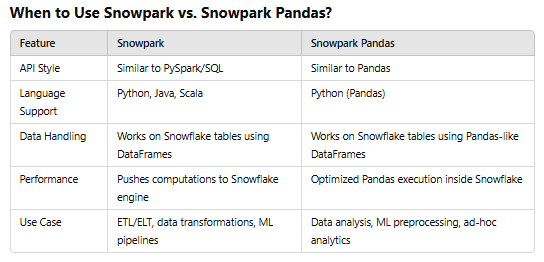

# Getting Started with pandas on Snowflake

[pandas on Snowflake](https://docs.snowflake.com/developer-guide/snowpark/python/snowpark-pandas) lets developers run their pandas code directly on their data in Snowflake. Users will be able to get the same pandas-native experience they know and love with Snowflake's performance, scale and governance.

In this quickstart, we'll show how you can get started with running pandas on Snowflake through the Snowpark pandas API. We'll also see that the Snowpark pandas API is very similar to the native pandas API and enables you to scale up your traditional pandas pipelines with just a few lines of change. You can run this notebook in a Snowflake Notebook. 

## Using Snowpark pandas API

The Snowpark pandas API is available as part of the Snowpark Python package (version 1.17 and above). Snowpark Python comes pre-installed with the Snowflake Notebooks environment. Additionally, you will need to add the `modin` package in the `Packages` dropdown.

- To install Modin, select `modin` from `Packages` and ensure the version is 0.28.1.

In [ ]:
# Import the Snowpark pandas plugin for modin
import snowflake.snowpark.modin.plugin
import modin.pandas as pd

## Create Snowpark session
Snowpark pandas requires an active `Session` object to connect to your data in Snowflake. In the next cell, we'll be initializing a Session object, and importing Snowpark pandas as `pd`. Make sure to use a database that you have write permissions on when creating the session, as Snowpark pandas requires write permissions.

In [ ]:
# Access current Snowpark session
from snowflake.snowpark.context import get_active_session
session = get_active_session()
# Add a query tag to the session for troubleshooting and monitoring
session.query_tag = {"origin":"sf_sit-is", 
                     "name":"pandas_on_snowflake", 
                     "version":{"major":1, "minor":0},
                     "attributes":{"is_quickstart":1, "source":"notebook", "vignette":"snowpark_pandas"}}

## Reading Data from Snowflake
Today, we'll be analyzing the time series data from the [Cybersyn Finance and Economics dataset](https://app.snowflake.com/marketplace/listing/GZTSZAS2KF7/cybersyn-inc-financial-economic-essentials). You can find the instructions to setup the dataset for this tutorial [here](https://quickstarts.snowflake.com/guide/getting_started_with_pandas_on_snowflake/#1). 

Let's start by reading the `stock_price_timeseries` table into a DataFrame!

Please double check that you have write permissions on the database that you initialized the Snowpark `Session` with. If you are reading from the `stock_price_timeseries` table, your `Session` needs to be configured to use a different database that you have write permissions on. The cell below uses the fully qualified name of the table to ensure that the read succeeds even though the `Session` is configured to use a different database.

In [ ]:
# Read data into a Snowpark pandas df 
from time import perf_counter
start = perf_counter()
spd_df = pd.read_snowflake("STOCK_PRICE_TIMESERIES")
end = perf_counter()
data_size = len(spd_df)
print(f"Took {end - start} seconds to read a table with {data_size} rows into Snowpark pandas!")
snow_time = end - start

Now let's do the same by reading the data into vanilla pandas. There are two common approach to doing this: 

1) Create a [Snowpark DataFrame](https://docs.snowflake.com/en/developer-guide/snowpark/python/working-with-dataframes#return-the-contents-of-a-dataframe-as-a-pandas-dataframe) and calling [`to_pandas`](https://docs.snowflake.com/developer-guide/snowpark/reference/python/latest/snowpark/api/snowflake.snowpark.DataFrame.to_pandas) to export results into a pandas DataFrame
```python
snowpark_df = session.table("FINANCIAL__ECONOMIC_ESSENTIALS.CYBERSYN.STOCK_PRICE_TIMESERIES")
native_pd_df = snowpark_df.to_pandas()
```

2) Use the [Snowflake Connector for Python](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-pandas) to query and export results from Snowflake into a pandas DataFrame using [`fetch_pandas_all`](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-api#fetch_pandas_all)

```python
# Create a cursor object
cur = session.connection.cursor()
# Execute a statement that will generate a result set
cur.execute("select * from FINANCIAL__ECONOMIC_ESSENTIALS.CYBERSYN.STOCK_PRICE_TIMESERIES")
# Fetch all the rows in a cursor and load them into a pandas DataFrame
native_pd_df = cur.fetch_pandas_all()
```

We will use the second approach below and measure the time these operations take. (Note: This may take several minutes!)

In [ ]:
start = perf_counter()
cur = session.connection.cursor()
cur.execute("select * from FINANCIAL__ECONOMIC_ESSENTIALS.CYBERSYN.STOCK_PRICE_TIMESERIES")
native_pd_df = cur.fetch_pandas_all()
end = perf_counter()
print(f"Native pandas took {end - start} seconds to read the data!")

As you can see, it takes much longer to export the Snowflake table into memory to operate with native pandas than for Snowpark pandas to read the table directly. This can also lead to the notebook session crashing if the exported data exceeds what can fit in memory.

## Examine The Raw Data
Let's take a look at the data we're going to be working with. We will inspect the first five rows of the dataframe and print them out using Streamlit's interactive dataframe display (`st.dataframe`).

In [ ]:
import streamlit as st
st.dataframe(spd_df.head(5))

## Filtering The Data
Let's take a look at some common data transformations - starting with filtering! Let's filter for stocks that are listed on the New York Stock Exchange!

In [ ]:
start = perf_counter()
nyse_spd_df = spd_df[(spd_df['PRIMARY_EXCHANGE_CODE'] == 'NYS')]
repr(nyse_spd_df)
end = perf_counter()
st.dataframe(nyse_spd_df.head())
print(f"Filtering for stocks belonging to the NYSE took {end - start} seconds in Snowpark pandas")

Let's try an even more granular filter - let's filter for the Pre-Market Open of stocks that have the following tickers:
* GOOG (Alphabet, Inc.)
* MSFT (Microsoft)
* SNOW (Snowflake)

In [ ]:
start = perf_counter()
filtered_spd_df = spd_df[((spd_df['TICKER'] == 'GOOG') | (spd_df['TICKER'] == 'MSFT') | (spd_df['TICKER'] == 'SNOW')) & (spd_df['VARIABLE_NAME'] == 'Pre-Market Open')]
repr(filtered_spd_df)
end = perf_counter()
st.dataframe(filtered_spd_df.head())
print(f"Filtering for the Pre-Market Open price for the above stocks took {end - start} seconds in Snowpark pandas")

# Reshaping the Data
Let's say we wanted to analyse the performance of various stock prices across time - in that case, it may be more helpful to have the values as columns, and the ticker name and date as the index - rather than the current encoding. We can accomplish this using the `pivot_table` API!

In [ ]:
start = perf_counter()
reshape_df = spd_df.pivot_table(index=["TICKER", "DATE"], columns="VARIABLE_NAME", values="VALUE")
repr(reshape_df)
end = perf_counter()
print(f"Pivoting the DataFrame took {end - start} seconds in Snowpark pandas")

In [ ]:
st.dataframe(reshape_df.head())

## Transforming the Data
Now that we have reformatted the data, we can beginn to apply some transformations. Let's start by taking a look at the All-Day Low column for the tickers above - we can resample the data to look at the Quarterly Low for the `GOOG` ticker!

In [ ]:
start = perf_counter()
resampled_spd_df_all_quarter_low = reshape_df["All-Day Low"]["GOOG"].resample("91D").min()
repr(resampled_spd_df_all_quarter_low)
end = perf_counter()
print(f"Resampling the DataFrame took {end - start} seconds in Snowpark pandas")

In [ ]:
print(resampled_spd_df_all_quarter_low)

We can even take a look at the quarter-over-quarter fluctuation in prices using the `diff` API!

In [ ]:
start = perf_counter()
q_o_q_resampled_spd_df_all_quarter_low = resampled_spd_df_all_quarter_low.diff()
repr(q_o_q_resampled_spd_df_all_quarter_low)
end = perf_counter()
print(f"Diffing the resampled data took {end - start} seconds in Snowpark pandas")

In [ ]:
print(q_o_q_resampled_spd_df_all_quarter_low)

## Apply function along an axis
Now we want to apply the absolute value square root on each value in the series. 
Snowpark pandas supports `apply`, which applies some arbitrary user-defined Python function along a particular axis of the DataFrame or Series. 

The Python function is serialized into Python bytecode and run this as a UDF inside Snowpark’s Python secure sandbox runtime environment. Snowpark's Python runtime environment is seamlessly integrated with the Anaconda package manager so that users can leverage their favorite third-party packages such as NumPy for flexible data transformation within their dataframe apply. 

**Pro Tip:** While calling `apply` is convenient, since the underlying implementation are UDF or UDTFs, it may not be as optimized as SQL queries transpiled from other Snowpark pandas queries. If the function applied has an equivalent dataframe or series operation, we recommend using those operations instead. For example, instead of `df.groupby('col1').apply('sum')`, directly call `df.groupby('col1').sum()`.

In [ ]:
import numpy as np
resampled_all_quarter_low_df_sqrt = q_o_q_resampled_spd_df_all_quarter_low.apply(
    lambda x: np.sqrt(abs(x))
)

In [ ]:
resampled_all_quarter_low_df_sqrt = resampled_all_quarter_low_df_sqrt.dropna()
print(resampled_all_quarter_low_df_sqrt)

## Visualizing your results with Altair

pandas is often used in conjunction with third-party visualization and machine learning libraries. Here we want to plot the quarter over quarter fluctuation in prices as a bar chart. 


First, let's clean up the data for plotting purposes.

In [ ]:
# Convert series to dataframe by resetting index
plot_df = q_o_q_resampled_spd_df_all_quarter_low.reset_index()
# Rename columns
plot_df.columns = ["DATE", "QLOW_DIFF"]
# Filter out extreme values
plot_df = plot_df[plot_df["QLOW_DIFF"]>-700]

When calling third-party library APIs with a Snowpark pandas dataframe, we recommend converting the Snowpark pandas dataframe to a pandas dataframe by calling [`to_pandas`](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/1.21.0/modin/pandas_api/snowflake.snowpark.modin.pandas.to_pandas) before passing the dataframe to the third-party library call. 

Note that calling to_pandas pulls your data out of Snowflake and into memory, so proceed with caution for large datasets and sensitive use cases. We generally recommend aggregating or summarizing and exporting only data that you will use for plotting using `to_pandas`.


In [ ]:
print("Input dataframe type: ", type(plot_df))
pandas_plot_df = plot_df.to_pandas()
print("After to_pandas, output dataframe type: ", type(pandas_plot_df))

Now we can use any Python visualization library, such as Altair, to plot the resulting pandas dataframe.

In [ ]:
import altair as alt
alt.Chart(pandas_plot_df).mark_bar(width=10).encode(
    x = alt.X("DATE:T"),
    y = alt.Y("QLOW_DIFF:Q"),
    color=alt.condition(
        alt.datum.QLOW_DIFF > 0,
        alt.value("steelblue"),  # The positive color
        alt.value("orange")  # The negative color
    )
)

### Conclusion
pandas on Snowflake unlocks the power of Snowflake for pandas developers by allowing you to run the same pandas API, while operating on large data sets that don't typically work with native pandas and all while keeping your data in Snowflake! To learn more, see [Snowflake Documentation](https://docs.snowflake.com/developer-guide/snowpark/python/snowpark-pandas). For a more advanced example, check out [this quickstart](https://quickstarts.snowflake.com/guide/data_engineering_pipelines_with_snowpark_pandas/) on how you can build a data engineering pipeline with Snowpark pandas.